# View simulated atmosphere

- author  :Sylvie Dagoret-Campagne
- affiliaiton : IJCLab/IN2P3/CNRS
- creation date : April 20th 2020
- update date :

In [33]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
import numpy as np
import pandas as pd
import os
import sys
%matplotlib inline

In [34]:
from astropy.io import fits

In [35]:
#to enlarge the sizes
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (10,6),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

In [36]:
plt.rcParams.update({'figure.max_open_warning': 0}) # to see a large number of files

In [37]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Configuration

In [38]:
DATADIR="../data/atm"

In [39]:
atmospheric_basename_files=os.listdir(DATADIR)

In [40]:
atmospheric_basename_files

['lsst_atm_10year_bintab.parquet',
 'lsst_atm_10year_01.fits',
 'lsst_atm_10year_bigimg.fits',
 'lsst_atm_10year_07.fits',
 'lsst_atm_10year_06.fits',
 'lsst_atm_10year_10.fits',
 'lsst_atm_10year_09.fits',
 'lsst_atm_10year_bintab.fits',
 'lsst_atm_10year_05.fits',
 'lsst_atm_10year_04.fits',
 'lsst_atm_10year_bintab_small.fits',
 'lsst_atm_10year_08.fits',
 'lsst_atm_10year_03.fits',
 '.ipynb_checkpoints',
 'lsst_atm_10year_02.fits']

In [41]:
inputfile=os.path.join(DATADIR,atmospheric_basename_files[2])

# Open all atmospheric files

In [42]:
idx=0
all_data=[]
all_hdr=[]
all_wl=[]
#for file in atmospheric_basename_files:
for file in [atmospheric_basename_files[2]]:  # now there is one big merged file
    
    if file.split(".")[-1]=="fits":
        inputfile=os.path.join(DATADIR,file)
        hdu = fits.open(inputfile)
        all_hdr.append(hdu[0].header)
        all_data.append(hdu[0].data[1:,:])
        all_wl.append(hdu[0].data[0,:])
        hdu.close()
        
    idx+=1
    
    

In [43]:
data=np.vstack(all_data)

## Extract info from header

### Pick up the header column index 

In [44]:
hdr=all_hdr[0]

In [45]:
NbAtmSimul=hdr['NBATMSIM']
idx_out_num=hdr['ID_NUM']
idx_out_year=hdr['ID_YEAR']
idx_out_am=hdr['ID_AM']
idx_out_vaod=hdr['ID_VAOD']
idx_out_pwv=hdr['ID_PWV']
idx_out_o3=hdr['ID_O3']
idx_out_cld=hdr['ID_CLD']
idx_out_res=hdr['ID_RES']

## Atmospheric data

In [46]:
vaod=data[1:,idx_out_vaod] # vertical aerosol depth
pwv=data[1:,idx_out_pwv]   # precipitable water vapor (mm)
o3=data[1:,idx_out_o3]     # ozone
cld=data[1:,idx_out_cld]   # clouds (not used)

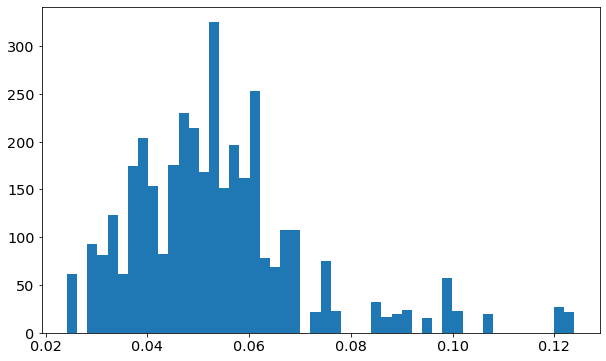

In [47]:
plt.hist(vaod,bins=50);

In [48]:
# Extract wavelength Wavelength
wl=all_wl[0][idx_out_res:]
transm=data[:,idx_out_res:]

In [49]:
transm_average=np.average(transm,axis=0)

In [50]:
transm.shape

(3650, 951)

In [51]:
NBSIM=transm.shape[0]

Text(0.5, 1.0, 'image of atmospheric simulation')

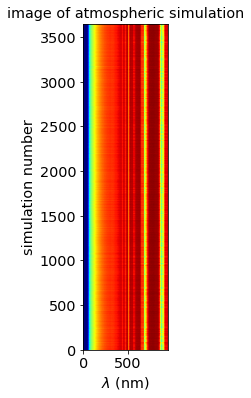

In [52]:
plt.imshow(transm,origin="lower",cmap='jet')
plt.xlabel("$\\lambda$ (nm)")
plt.ylabel("simulation number")
plt.title("image of atmospheric simulation")

In [53]:
# bins in wevelength
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=NBSIM)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(NBSIM), alpha=1)

Text(0.5, 1.0, 'Atmospheric transparency')

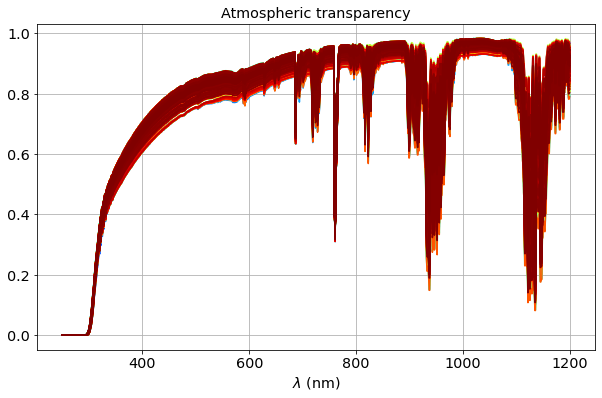

In [54]:
for idx in np.arange(NBSIM):
    colorVal=scalarMap.to_rgba(idx, alpha=1)
    plt.plot(wl,transm[idx,:],color=colorVal)
plt.grid(True)
plt.xlabel("$\lambda$ (nm)")
plt.title("Atmospheric transparency")

# Find worse and best atmosphere and average transmission

In [56]:
transmsum=np.zeros(NBSIM)
for idx in np.arange(NBSIM):
    transmsum[idx]=transm[idx,:].sum()

In [57]:
idx_best_atm=np.where(transmsum==transmsum.min())[0][0]

In [58]:
idx_worse_atm=np.where(transmsum==transmsum.max())[0][0]

Text(0.5, 1.0, 'Atmospheric transparency')

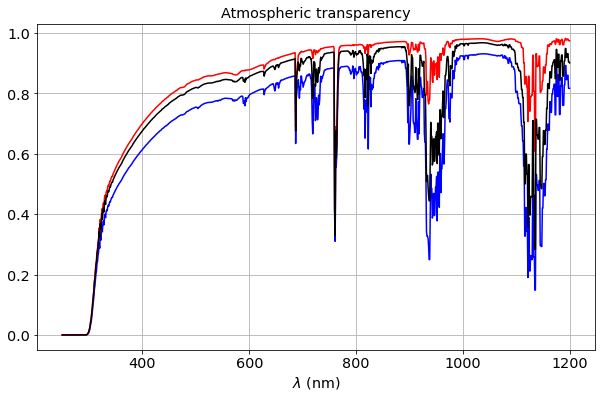

In [60]:
plt.plot(wl,transm[idx_best_atm,:],color="b")
plt.plot(wl,transm[idx_worse_atm,:],color="r")
plt.plot(wl,transm_average,"k-")

plt.grid(True)
plt.xlabel("$\lambda$ (nm)")
plt.title("Atmospheric transparency")

In [62]:
df=pd.DataFrame()
df["wl"]=wl
df["transm0"]=transm_average
df["transmworse"]=transm[idx_worse_atm,:]
df["transmbest"]=transm[idx_best_atm,:]

In [63]:
df.to_csv("basic_atmtransmavermimax.csv")